In [ ]:
!pip install -U -qq datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.9 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data import DataLoader, random_split
from datasets import load_dataset
from torchvision.transforms.functional import InterpolationMode
import json
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
from torch.utils.data import Subset
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## Helper Functions


In [ ]:
def imshow(img, one_channel=False):
    img = img.numpy().transpose((1, 2, 0))  # Convert from Tensor image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean  # denormalize
    img = np.clip(img, 0, 1)  # ensure img values are within [0, 1]
    if one_channel:
        img = img.mean(axis=2)
    plt.imshow(img)
    plt.show()

def show_images(dataset, num_images=4):
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(dataloader))  # Get a batch of images

    # Create a grid of images
    img_grid = make_grid(images)

    # Show images and label
    imshow(img_grid)
    print('Labels:', labels)

def load_checkpoint(epoch, model, optimizer, scheduler, base_path='/content/drive/MyDrive/CMPE_DL_for_CV_Project/feature_extractor/ViT_B_16_IMAGENET1K_SWAG_E2E_V1_batch_size_128/epoch'):
    checkpoint_path = f"{base_path}{epoch}_checkpoint.pth"
    losses_path = f"{base_path}{epoch}_losses.json"
    lr_path = f"{base_path}{epoch}_lr.json"
    val_accuracies_path = f"{base_path}{epoch}_val_accuracies.json"
    val_losses_path = f"{base_path}{epoch}_val_losses.json"

    # Load the model, optimizer, and scheduler states
    if torch.cuda.is_available():
        checkpoint = torch.load(checkpoint_path)
    else:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    # Load losses and other metrics
    with open(losses_path, 'r') as f:
        losses = json.load(f)
    with open(lr_path, 'r') as f:
        lr = json.load(f)
    with open(val_accuracies_path, 'r') as f:
        val_accuracies = json.load(f)
    with open(val_losses_path, 'r') as f:
        val_losses = json.load(f)

    return {
        'model': model,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'losses': losses,
        'learning_rate': lr,
        'validation_accuracies': val_accuracies,
        'validation_losses': val_losses
    }



## Model & Data Setup

In [ ]:
# Initialize a global list to store attention weights
attention_weights_list = []

In [ ]:
# Load the pretrained model
model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)
model.heads.head = nn.Linear(model.heads.head.in_features, 200)

In [ ]:
# Loading from checkpoint
epoch_number = 24
optimizer = optim.AdamW(model.parameters(), lr=0.0005)  # Optimize only the head
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.2, total_iters=25, )
results = load_checkpoint(epoch_number, model, optimizer, scheduler, base_path='/content/drive/MyDrive/CMPE_DL_for_CV_Project/fine_tuning/ViT_B_16_IMAGENET1K_SWAG_E2E_V1_batch_size_16_attention_only/epoch')

In [ ]:
model = results['model']

In [ ]:
# Freeze all parameters in the model, since we will use it as a feature extractor
for param in model.parameters():
    param.requires_grad = False

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device);


In [ ]:
def new_self_attention(self, query, key, value, need_weights=False):
    # Invoke the original method properly, ensuring all arguments are passed correctly
    output, weights = self.original_self_attention(query, key, value, need_weights=True)

    # Append the attention weights to the global list
    attention_weights_list.append(weights.detach().cpu())  # Detach and move to CPU for easier handling

    return output, weights

In [ ]:
def patch_vit_model(model):
    for block in model.encoder.layers:
        block.self_attention.original_self_attention = block.self_attention.forward
        block.self_attention.forward = new_self_attention.__get__(block.self_attention, block.self_attention.__class__)


# Apply the patch
patch_vit_model(model)


In [ ]:
for i in model.encoder.layers:
  print(i.self_attention.forward)
  break

<bound method new_self_attention of MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
)>


In [ ]:
# Modified transform functions, some augmentation is added in train_preprocess
train_preprocess = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert grayscale to RGB if needed
    transforms.Resize((384,384), interpolation=InterpolationMode.BICUBIC),  # Resize the image to 256x256
    #transforms.CenterCrop(384),  # Crop the image to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly change brightness, contrast, and saturation
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),  # Random affine transformation
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])

test_preprocess = transforms.Compose([
    transforms.Lambda(lambda x: x.convert('RGB')),  # Convert grayscale to RGB if needed
    transforms.Resize((384,384), interpolation=InterpolationMode.BICUBIC),
    #transforms.CenterCrop(384),
    transforms.ToTensor(),  # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the image
])


### Load CUB Dataset

In [ ]:
#dataset = load_dataset('AI-Lab-Makerere/beans')
dataset = load_dataset('efekankavalci/CUB_200_2011')

In [ ]:
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform=None, indices=None):
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.indices = list(range(len(hf_dataset))) if indices is None else indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        true_idx = self.indices[idx]
        item = self.hf_dataset[true_idx]
        image = item['image']
        label = item['label']

        if self.transform:
            image = self.transform(image)

        return image, label

train_dataset = HFDataset(dataset['train'], transform=train_preprocess)
test_dataset = HFDataset(dataset['test'], transform=test_preprocess)


In [ ]:
# Check the train-val split
len(train_dataset), len(test_dataset)

(5994, 5794)

In [ ]:
bs = 32 # batch size
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=False)

### Attention Map

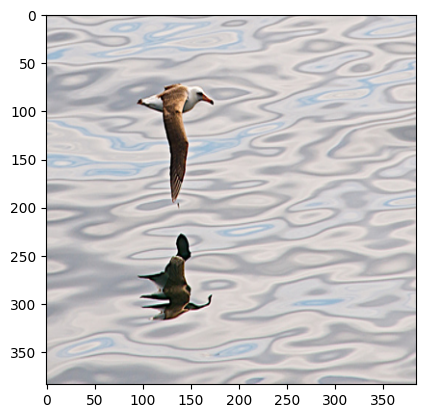

In [ ]:
i = 59
input_tensor = test_dataset[i][0]
input_label = test_dataset[i][1]  # your input tensor
imshow(input_tensor)

In [ ]:
input_tensor = input_tensor[None, :, :, :]
input_tensor = input_tensor.to(device)
input_tensor.shape


torch.Size([1, 3, 384, 384])

In [ ]:
# Clear previous stored weights
attention_weights_list.clear()

# Run a forward pass with an input tensor `input_tensor`
output = model(input_tensor)

# After the forward pass, `attention_weights_list` will contain the attention weights from each block

In [ ]:
output.shape
_, predicted = torch.max(output.data, 1)
print(f"Predicted label {predicted[0]}" )
print(f"True label {input_label}")

Predicted label 1
True label 1


In [ ]:
print(attention_weights_list[0][0].shape)
print(attention_weights_list[0][0, 0, 0:].sum()) # Check that this is the normalized dimension

torch.Size([577, 577])
tensor(1.0000)


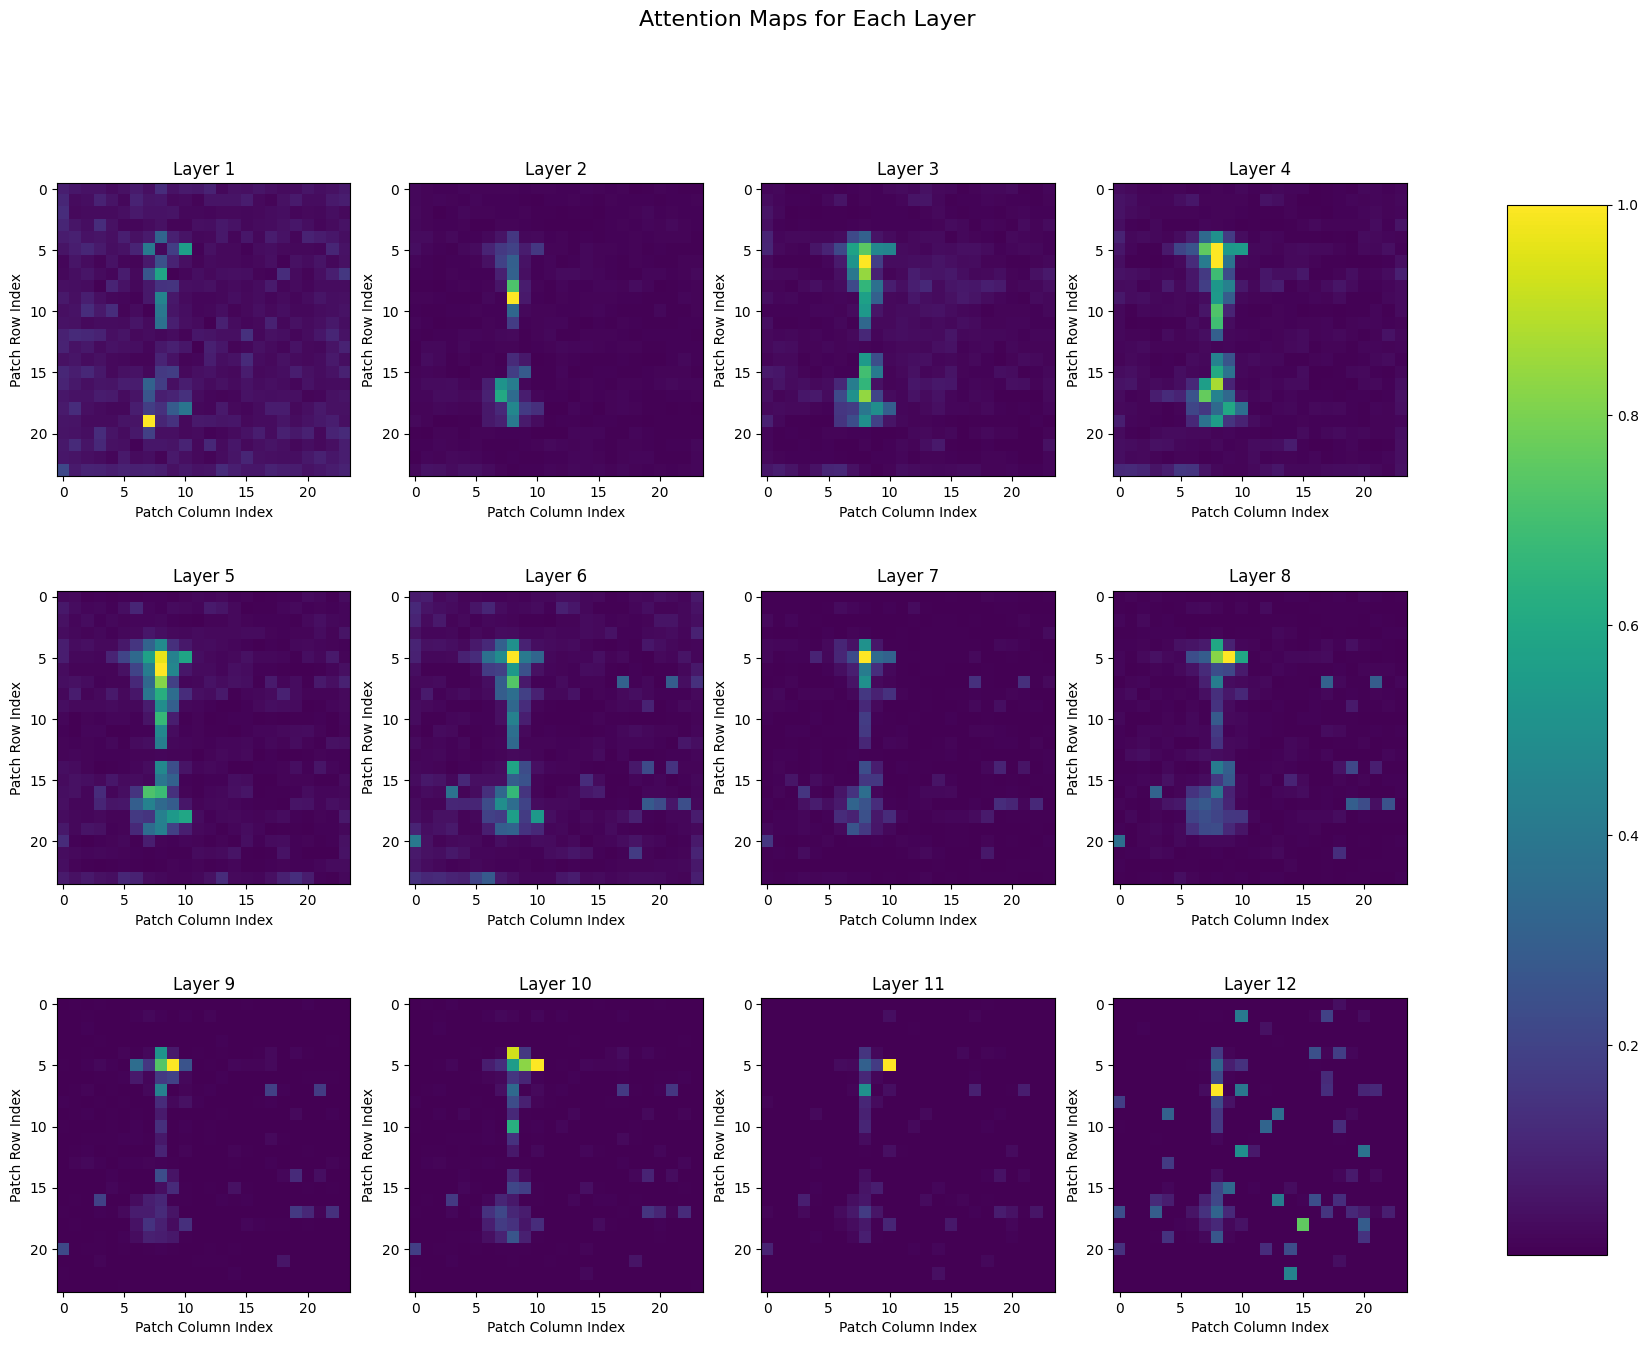

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(20, 15))
fig.suptitle('Attention Maps for Each Layer', fontsize=16)

for layer in range(12):
    ax = axes[layer // 4, layer % 4]

    # Extract the class token attention weights, skip the first value which is the class token self-attention
    class_token_attention = attention_weights_list[layer][0, 0, 1:]

    # Reshape to 24x24
    class_token_attention = class_token_attention.view(24, 24)

    # Normalize for better visualization
    class_token_attention = class_token_attention / class_token_attention.max()

    # Plot
    im = ax.imshow(class_token_attention.cpu().numpy(), cmap='viridis', interpolation='nearest')
    ax.set_title(f'Layer {layer + 1}')
    ax.set_xlabel('Patch Column Index')
    ax.set_ylabel('Patch Row Index')

# Create space on the right of the subplots for the colorbar
fig.subplots_adjust(right=0.8)

# Add a colorbar
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7]) # [right, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.show()


In [ ]:
def attention_rollout(attention_weights_list):
    rollout = torch.eye(attention_weights_list[0].shape[-1]).to(attention_weights_list[0].device)

    # Iterate over each attention matrix from the first to the last
    for attn in attention_weights_list:
        rollout = torch.matmul(attn.squeeze(0), rollout)

    return rollout


# Compute the attention rollout
rollout_matrix = attention_rollout(attention_weights_list)

# Now `rollout_matrix` contains the rolled-out attention that can be used for visualization
print(rollout_matrix.shape)  # Should print: torch.Size([577, 577])


torch.Size([577, 577])


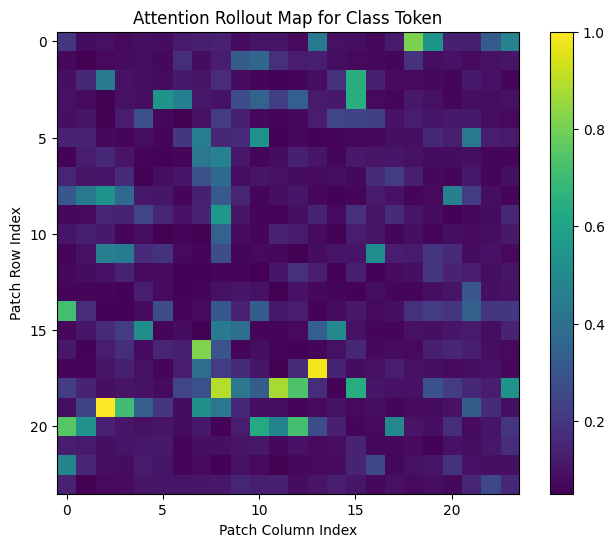

In [ ]:
class_token_attention_rollout = rollout_matrix[0, 1:]  # Skip the first value which is the class token self-attention

# Reshape to 24x24
class_token_attention_rollout = class_token_attention_rollout.view(24, 24)

# Normalize for better visualization
class_token_attention_rollout = class_token_attention_rollout / class_token_attention_rollout.max()

# Create a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(class_token_attention_rollout.cpu().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('Attention Rollout Map for Class Token')
plt.xlabel('Patch Column Index')
plt.ylabel('Patch Row Index')
plt.show()
